In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import uproot

In [2]:
rng = np.random.Generator(np.random.PCG64(42))

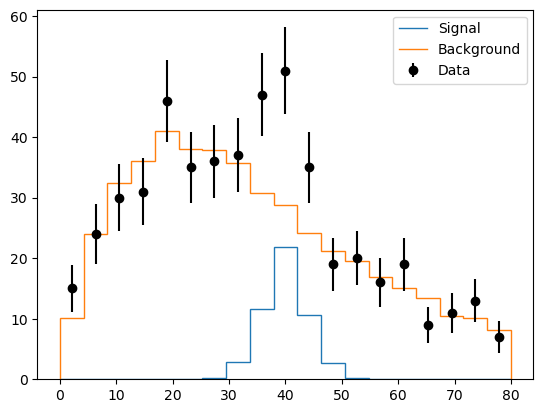

In [3]:
sig_mass = rng.normal(loc=40.0, scale=4.0, size=1_000)
sig_w = np.ones_like(sig_mass) * 0.05

bkg_mass = rng.exponential(scale=20.0, size=10_000) + rng.exponential(scale=20.0, size=10_000)
bkg_w = np.ones_like(bkg_mass) * 0.05

edges = np.linspace(0, 80, 20)
centers = 0.5*(edges[1:] + edges[:-1])
sig_hist = np.histogram(sig_mass, bins=edges, weights=sig_w)
bkg_hist = np.histogram(bkg_mass, bins=edges, weights=bkg_w)

data_obs = rng.poisson(1.0 * sig_hist[0] + bkg_hist[0])

fig, ax = plt.subplots()
ax.stairs(*sig_hist, label="Signal")
ax.stairs(*bkg_hist, label="Background")
ax.errorbar(
    x=centers, y=data_obs, yerr=np.sqrt(data_obs),
    linestyle="none", marker="o", color="k", label="Data"
)
ax.legend();

In [4]:
from scipy.special import xlogy

def poisson_logprob(n, λ):
    """log(λ^n e^-λ)"""
    return xlogy(n, λ) - λ


@np.vectorize
def nll(mu):
    return -poisson_logprob(data_obs, mu*sig_hist[0] + bkg_hist[0]).sum()


def nll_inherently_vectorized(mu):
    return -poisson_logprob(data_obs, mu[:, None]*sig_hist[0] + bkg_hist[0]).sum(axis=1)


mus = np.linspace(0, 3, 10000)
%timeit nll(mus)
%timeit nll_inherently_vectorized(mus)

38.3 ms ± 60.3 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
2.52 ms ± 35.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


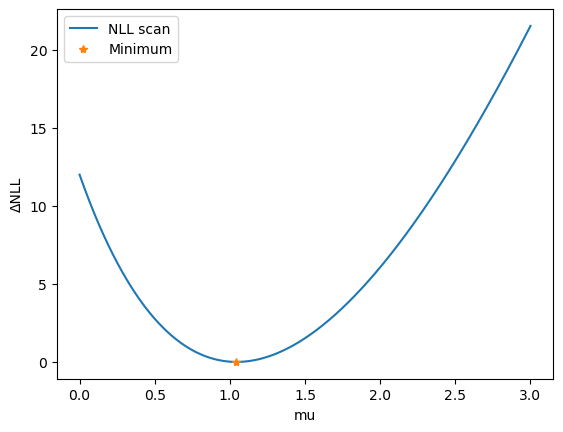

In [5]:
from scipy.optimize import minimize

fit = minimize(nll, 0.0)

fig, ax = plt.subplots()

ax.plot(mus, nll(mus) - fit.fun, label="NLL scan")
ax.plot(fit.x, 0.0, marker="*", linestyle="none", label="Minimum")
ax.set_xlabel("mu")
ax.set_ylabel("ΔNLL")
ax.legend();

In [6]:
with uproot.recreate("shapes.root") as fout:
    fout["sig"] = sig_hist
    fout["bkg"] = bkg_hist
    fout["data_obs"] = (data_obs, edges)

Welcome to JupyROOT 6.26/04


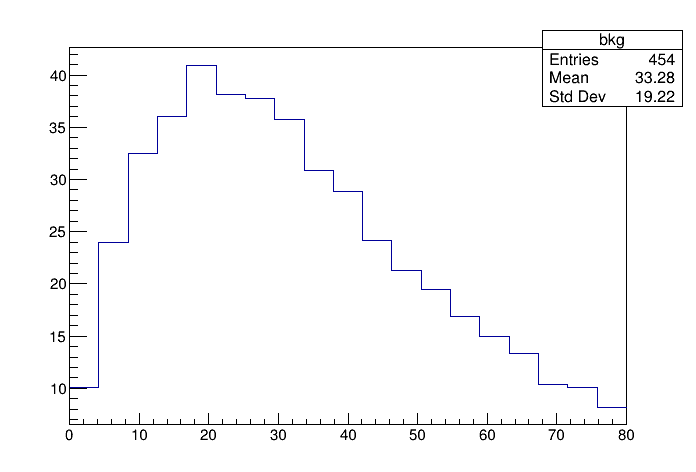

In [7]:
import ROOT

fin = ROOT.TFile.Open("shapes.root")
c1 = ROOT.TCanvas()
fin.Get("bkg").Draw()
c1.Draw()

In [8]:
data_obs.sum(), sig_hist[0].sum(), bkg_hist[0].sum()

(501, 49.999999999999304, 453.65000000006887)

In [9]:
import os

os.environ["PATH"] += ":/tmp/HiggsAnalysis/CombinedLimit/build/bin"
os.environ["LD_LIBRARY_PATH"] += ":/tmp/HiggsAnalysis/CombinedLimit/build/lib"
os.environ["PYTHONPATH"] = "/tmp/HiggsAnalysis/CombinedLimit/build/lib/python"

In [12]:
%env PATH=opt/conda/bin/:/opt/conda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/tmp/HiggsAnalysis/CombinedLimit/build/bin
%env LD_LIBRARY_PATH=/opt/conda/lib/:/tmp/HiggsAnalysis/CombinedLimit/build/lib
%env PYTHONPATH=/tmp/HiggsAnalysis/CombinedLimit/build/lib/python

env: PATH=opt/conda/bin/:/opt/conda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/tmp/HiggsAnalysis/CombinedLimit/build/bin
env: LD_LIBRARY_PATH=/opt/conda/lib/:/tmp/HiggsAnalysis/CombinedLimit/build/lib
env: PYTHONPATH=/tmp/HiggsAnalysis/CombinedLimit/build/lib/python


In [13]:
%%writefile card.txt
imax 1 number of channels
jmax 1 number of backgrounds
kmax 1 number of systematics
shapes * * shapes.root $PROCESS
---
bin bin1
observation 481
---
bin       bin1    bin1
process      0       1
process    sig     bkg
rate        50   455.1
---
lumi lnN  1.03    1.03

Overwriting card.txt


In [14]:
%%bash

combine -M MultiDimFit card.txt --algo grid --setParameterRanges r=0,3 --trackParameters lumi

bash: line 2: combine: command not found


CalledProcessError: Command 'b'\ncombine -M MultiDimFit card.txt --algo grid --setParameterRanges r=0,3 --trackParameters lumi\n'' returned non-zero exit status 127.

In [14]:
with uproot.open("higgsCombineTest.MultiDimFit.mH120.root") as fin:
    data = fin["limit"].arrays()

bestfit = data[0]
scan = data[1:]

KeyInFileError: not found: 'limit' (with any cycle number)

    Available keys: 'toys;1'

in file higgsCombineTest.MultiDimFit.mH120.root

In [12]:
def full_nll(mu, lumi_np):
    expectation = mu*sig_hist[0] + bkg_hist[0]
    expectation *= 1.03**lumi_np
    poisson_term = -poisson_logprob(data_obs, expectation).sum()
    aux_term = 0.5 * lumi_np**2
    return poisson_term + aux_term

@np.vectorize
def profile_nll(mu):
    fit = minimize(lambda lumi_np: full_nll(mu, lumi_np), 0.0)
    return fit.fun

NameError: name 'scan' is not defined

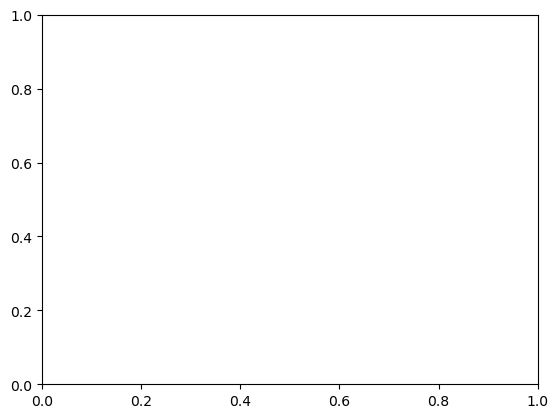

In [13]:
fig, ax = plt.subplots()

our_nll = profile_nll(scan.r) - profile_nll(bestfit.r)

ax.plot(scan.r, scan.deltaNLL, label="ΔNLL")
ax.plot(bestfit.r, 0.0, marker="*", label="Best fit")
ax.plot(scan.r, our_nll, label="Our NLL")
ax.axhline(0.5* 3.8**2)
ax.set_xlabel("μ")
ax.set_ylabel("ΔNLL")
ax.legend()

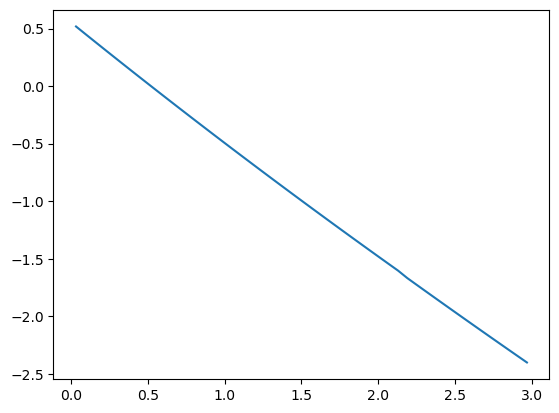

In [130]:
plt.plot(scan.r, scan.trackedParam_lumi)

In [116]:
q0 = 2*(profile_nll(0) - profile_nll(bestfit.r))

np.sqrt(q0)

3.893116061287135

In [117]:
%%bash

combine -M Significance card.txt

 <<< Combine >>> 
 <<< v10.0.0 >>>
>>> Random number generator seed is 123456
>>> Method used is Significance

 -- Significance -- 
Significance: 3.89312
Done in 0.00 min (cpu), 0.00 min (real)


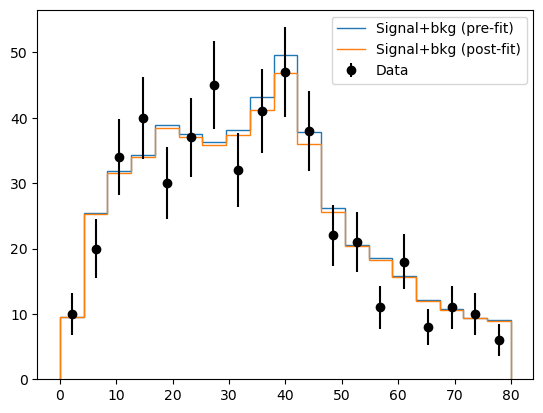

In [129]:
fig, ax = plt.subplots()

expectation = (bestfit.r * sig_hist[0] + bkg_hist[0]) * 1.03**bestfit.trackedParam_lumi

ax.stairs(sig_hist[0] + bkg_hist[0], edges=edges, label="Signal+bkg (pre-fit)")
ax.stairs(expectation, edges=edges, label="Signal+bkg (post-fit)")
ax.errorbar(
    x=centers, y=data_obs, yerr=np.sqrt(data_obs),
    linestyle="none", marker="o", color="k", label="Data"
)
ax.legend()